In [1]:
import pandas as pd
import numpy as np
from pennylane import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from pennylane.optimize import AdamOptimizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import time

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('grib_data.csv', sep=',')

def convert_to_numeric(df, column_name):
    df[column_name] = pd.to_datetime(df[column_name], errors='coerce').astype(np.int64) / 1e9  # Convert to Unix timestamp

=for col in ['time', 'step', 'valid_time']:
    convert_to_numeric(df, col)

df = df.astype(float)

train, test = train_test_split(df, test_size=0.30, random_state=2)

train_set = train.sample(160, random_state=42)
test_set = test.sample(40, random_state=42)

np.random.seed(42)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359775 entries, 0 to 359774
Data columns (total 70 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   time                 359775 non-null  float64
 1   latitude             359775 non-null  float64
 2   longitude            359775 non-null  float64
 3   number               359775 non-null  float64
 4   step                 359775 non-null  float64
 5   surface              359775 non-null  float64
 6   valid_time           359775 non-null  float64
 7   u100                 359775 non-null  float64
 8   v100                 359775 non-null  float64
 9   u10n                 359775 non-null  float64
 10  u10                  359775 non-null  float64
 11  v10n                 359775 non-null  float64
 12  v10                  359775 non-null  float64
 13  d2m                  359775 non-null  float64
 14  t2m                  359775 non-null  float64
 15  meanSea          

In [4]:
df.describe()

,time,latitude,longitude,number,step,surface,valid_time,u100,v100,u10n,...,stl1,slt,sdfor,sdor,sp,tsn,tcc,tciw,tclw,tco3
count,3.597750e+05,359775.000000,359775.000000,359775.0,3.597750e+05,359775.0,3.597750e+05,359775.000000,359775.000000,359775.000000,...,359775.000000,359775.000000,359775.000000,359775.000000,359775.000000,359775.000000,359775.000000,359775.000000,359775.000000,359775.000000
mean,1.705108e+09,21.990000,82.670000,0.0,-9.223372e+09,0.0,1.705108e+09,-1.389359,-1.447951,-1.265897,...,285.773462,1.889584,67.941117,94.489307,89724.177824,276.160228,0.418842,0.005182,0.026459,0.005839
std,6.230401e+05,8.876479,8.443451,0.0,1.587298e-02,0.0,6.230401e+05,2.909469,2.929684,2.141267,...,16.737633,1.581977,112.114888,147.960510,17612.564356,22.047783,0.378391,0.027872,0.060537,0.000687
min,1.704071e+09,6.740000,68.170000,0.0,-9.223372e+09,0.0,1.704071e+09,-13.360776,-12.394982,-11.429073,...,241.089450,0.000000,0.000000,0.000000,48842.492000,223.589070,0.000000,0.000000,0.000000,0.004930
25%,1.704589e+09,14.240000,75.420000,0.0,-9.223372e+09,0.0,1.704589e+09,-3.436470,-3.569078,-2.226872,...,276.682680,0.000000,0.000000,0.000000,86302.818000,272.347230,0.029724,0.000000,0.000000,0.005292
50%,1.705108e+09,21.990000,82.670000,0.0,-9.223372e+09,0.0,1.705108e+09,-1.179940,-1.237203,-0.480583,...,290.270630,2.000000,12.004761,20.667542,99471.280000,273.161070,0.322571,0.000004,0.002869,0.005592
75%,1.705626e+09,29.740000,89.920000,0.0,-9.223372e+09,0.0,1.705626e+09,0.523396,0.577265,0.125910,...,300.553815,3.000000,88.463560,130.827580,101245.766000,300.468020,0.816681,0.000853,0.027557,0.006239
max,1.706144e+09,37.240000,97.170000,0.0,-9.223372e+09,0.0,1.706144e+09,12.678922,9.792582,7.389265,...,303.333280,7.000000,692.202330,923.084700,102031.625000,303.332950,1.000000,1.421082,1.204315,0.009016


In [5]:
df.head()

,time,latitude,longitude,number,step,surface,valid_time,u100,v100,u10n,...,stl1,slt,sdfor,sdor,sp,tsn,tcc,tciw,tclw,tco3
0,1.704071e+09,37.24,68.17,0.0,-9.223372e+09,0.0,1.704071e+09,-2.245291,-0.776336,-0.399831,...,277.32510,2.0,110.161500,127.059630,96868.28,273.15945,0.0,0.0,0.0,0.007600
1,1.704071e+09,37.24,68.42,0.0,-9.223372e+09,0.0,1.704071e+09,-2.133474,-1.552703,-0.324147,...,277.53604,2.0,83.488040,96.797850,97332.28,273.15945,0.0,0.0,0.0,0.007598
2,1.704071e+09,37.24,68.67,0.0,-9.223372e+09,0.0,1.704071e+09,-2.347830,-1.889617,-0.607595,...,278.08292,2.0,46.477905,67.010254,97679.28,273.15945,0.0,0.0,0.0,0.007593
3,1.704071e+09,37.24,68.92,0.0,-9.223372e+09,0.0,1.704071e+09,-2.571707,-1.820525,-1.247975,...,278.70108,2.0,46.584840,83.773865,96807.28,273.15945,0.0,0.0,0.0,0.007574
4,1.704071e+09,37.24,69.17,0.0,-9.223372e+09,0.0,1.704071e+09,-2.128103,-1.222381,-1.059499,...,278.15323,2.0,90.897644,142.714780,95726.28,273.15945,0.0,0.0,0.0,0.007550


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(train_set)
X_test = scaler.transform(test_set)


In [13]:
import pennylane as qml
from pennylane.templates import AngleEmbedding

# Define a quantum device
dev = qml.device("default.qubit", wires=4)

# Define a quantum node
@qml.qnode(dev)
def quantum_model(params, x):
    AngleEmbedding(x, wires=[0, 1, 2, 3])
    qml.templates.layers.BasicEntanglerLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0))

# Example function to get quantum predictions
def get_predictions(X):
    predictions = []
    for x in X:
        params = np.random.rand(3, 4)
        pred = quantum_model(params, x)
        predictions.append(pred)
    return np.array(predictions)


In [15]:
import pandas as pd
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
from pennylane import QNode, Hadamard, CNOT, RX, RZ, Z
from pennylane.templates import AngleEmbedding
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import time

start = time.time()

df = pd.read_csv('grib_data.csv', sep=',')

def convert_to_numeric(df, column_name):
    df[column_name] = pd.to_datetime(df[column_name], errors='coerce').astype(np.int64) / 1e9  # Convert to Unix timestamp

for col in ['time', 'step', 'valid_time']:
    convert_to_numeric(df, col)

df = df.astype(float)

imputer = SimpleImputer(strategy='mean')  # You can also use other strategies like median or most_frequent
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

train, test = train_test_split(df_imputed, test_size=0.30, random_state=2)

train_set = train.sample(160, random_state=42)
test_set = test.sample(40, random_state=42)

np.random.seed(42)

scaler = StandardScaler()
X_train = scaler.fit_transform(train_set.drop(columns=['latitude', 'longitude']))
X_test = scaler.transform(test_set.drop(columns=['latitude', 'longitude']))

lat_train = train_set[['latitude', 'longitude']].values
lat_test = test_set[['latitude', 'longitude']].values

n_qubits = 3

pca = PCA(n_components=n_qubits - 1)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

def get_matrix_and_vector():
    A = np.array([[1, 2], [3, 4]])
    b = np.array([1, 0])
    return A, b

dev_qpe = qml.device("default.qubit", wires=3)

@qml.qnode(dev_qpe)
def qpe_circuit():
    for i in range(2):
        Hadamard(wires=i)
    
    for i in range(2):
        CNOT(wires=[i, 2])

    for i in range(2):
        RZ(np.pi / 4, wires=i)

    return qml.expval(qml.PauliZ(0))

dev_hhl = qml.device("default.qubit", wires=3)

@qml.qnode(dev_hhl)
def hhl_algorithm(params, b):
    AngleEmbedding(b, wires=[0, 1])

    for i in range(2):
        RX(params[i], wires=i)
    
    for i in range(2):
        RZ(params[i], wires=2)

    return qml.expval(qml.PauliZ(0))

def solve_linear_system(A, b):
    # Perform QPE
    qpe_result = qpe_circuit()

    # Solve using HHL
    params = [np.pi / 4, np.pi / 2]
    return hhl_algorithm(params, b)

def get_predictions(X):
    predictions = []
    for x in X:
        A, b = get_matrix_and_vector()
        pred = solve_linear_system(A, x)
        predictions.append(pred)
    return np.array(predictions)

y_train_pred = get_predictions(X_train_reduced)
y_test_pred = get_predictions(X_test_reduced)

threshold = np.percentile(y_train_pred, 95)  # Example threshold

train_anomalies = y_train_pred > threshold
test_anomalies = y_test_pred > threshold

train_confidence = y_train_pred[train_anomalies]
test_confidence = y_test_pred[test_anomalies]

train_anomalies_lat_lon = lat_train[train_anomalies]
test_anomalies_lat_lon = lat_test[test_anomalies]

print(f"Train anomalies latitude/longitude shape: {train_anomalies_lat_lon.shape}")
print(f"Train confidence shape: {train_confidence.shape}")
print(f"Test anomalies latitude/longitude shape: {test_anomalies_lat_lon.shape}")
print(f"Test confidence shape: {test_confidence.shape}")

print("Train anomalies:")
for i, (lat_lon, conf) in enumerate(zip(train_anomalies_lat_lon, train_confidence)):
    lat, lon = lat_lon
    print(f"Anomaly {i + 1}: Latitude={lat}, Longitude={lon}, Confidence={conf:.4f}")

print("\nTest anomalies:")
for i, (lat_lon, conf) in enumerate(zip(test_anomalies_lat_lon, test_confidence)):
    lat, lon = lat_lon
    print(f"Anomaly {i + 1}: Latitude={lat}, Longitude={lon}, Confidence={conf:.4f}")

print(f"\nExecution time: {time.time() - start:.2f} seconds")


Train anomalies latitude/longitude shape: (8, 2)
Train confidence shape: (8,)
Test anomalies latitude/longitude shape: (0, 2)
Test confidence shape: (0,)
Train anomalies:
Anomaly 1: Latitude=8.490000000000002, Longitude=75.67, Confidence=0.9984
Anomaly 2: Latitude=29.24, Longitude=90.92, Confidence=0.9995
Anomaly 3: Latitude=35.24, Longitude=93.42, Confidence=0.9977
Anomaly 4: Latitude=29.74, Longitude=88.67, Confidence=0.9975
Anomaly 5: Latitude=7.490000000000002, Longitude=70.17, Confidence=0.9971
Anomaly 6: Latitude=16.240000000000002, Longitude=69.42, Confidence=1.0000
Anomaly 7: Latitude=7.240000000000002, Longitude=85.92, Confidence=0.9987
Anomaly 8: Latitude=28.74, Longitude=92.17, Confidence=0.9974

Test anomalies:

Execution time: 12.05 seconds


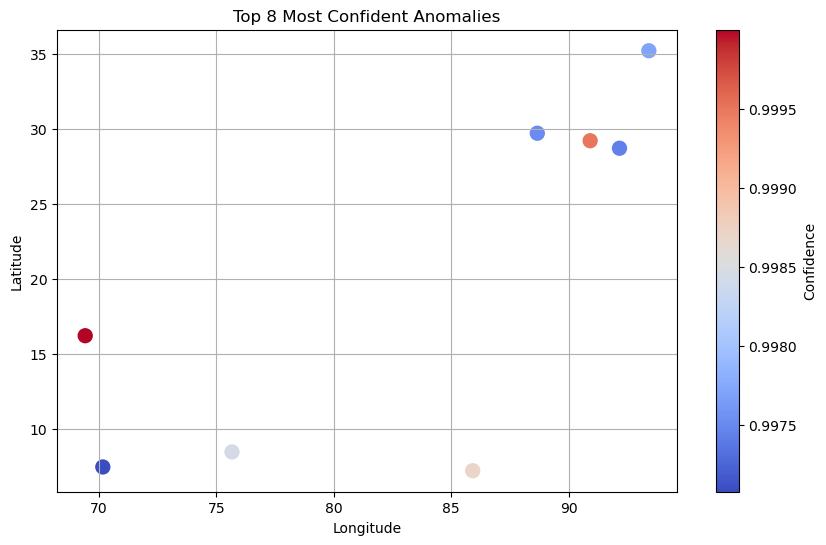

Top 5 Anomaly Map saved as 'top_5_anomaly_map.html'


In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import folium

anomalies_df = pd.DataFrame({
    'latitude': train_anomalies_lat_lon[:, 0],
    'longitude': train_anomalies_lat_lon[:, 1],
    'confidence': train_confidence
})

anomalies_df_sorted = anomalies_df.sort_values(by='confidence', ascending=False)

top_20_anomalies = anomalies_df_sorted.head(20)

plt.figure(figsize=(10, 6))
plt.scatter(top_20_anomalies['longitude'], top_20_anomalies['latitude'],
            c=top_20_anomalies['confidence'], cmap='coolwarm', s=100)
plt.colorbar(label='Confidence')
plt.title('Top 8 Most Confident Anomalies')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

top_5_anomalies = anomalies_df_sorted.head(5)
map_center_top_5 = [top_5_anomalies['latitude'].mean(), top_5_anomalies['longitude'].mean()]
top_5_anomaly_map = folium.Map(location=map_center_top_5, zoom_start=5)

for _, row in top_5_anomalies.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Confidence: {row['confidence']:.4f}",
        icon=folium.Icon(color='blue')
    ).add_to(top_5_anomaly_map)

top_5_anomaly_map.save('top_5_anomaly_map_quantum.html')

print("Top 5 Anomaly Map saved as 'top_5_anomaly_map.html'")


In [19]:
import folium
from folium import plugins

# Initialize the map centered around the median latitude and longitude of the anomalies
center_lat = np.median(np.concatenate([train_anomalies_lat_lon[:, 0], test_anomalies_lat_lon[:, 0]]))
center_lon = np.median(np.concatenate([train_anomalies_lat_lon[:, 1], test_anomalies_lat_lon[:, 1]]))
m = folium.Map(location=[center_lat, center_lon], zoom_start=5)

# Function to add anomaly markers to the map
def add_anomaly_markers(m, lat_lon_array, confidence_scores, anomaly_type="Train"):
    for i, (lat_lon, conf) in enumerate(zip(lat_lon_array, confidence_scores)):
        folium.Marker(
            location=[lat_lon[0], lat_lon[1]],
            popup=f"{anomaly_type} Anomaly {i + 1}: Confidence={conf:.4f}",
            icon=folium.Icon(color="red" if anomaly_type == "Test" else "blue"),
        ).add_to(m)

# Add training anomalies
add_anomaly_markers(m, train_anomalies_lat_lon, train_confidence, anomaly_type="Train")

# Add testing anomalies
add_anomaly_markers(m, test_anomalies_lat_lon, test_confidence, anomaly_type="Test")

# Add a mini map for better navigation
plugins.MiniMap().add_to(m)

# Save to HTML file
m.save("anomaly_map_quantum.html")


In [23]:
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns

m_heatmap = folium.Map(location=[center_lat, center_lon], zoom_start=5)

train_heat_data = [[lat_lon[0], lat_lon[1]] for lat_lon in train_anomalies_lat_lon]
test_heat_data = [[lat_lon[0], lat_lon[1]] for lat_lon in test_anomalies_lat_lon]

HeatMap(train_heat_data, name="Train Anomalies Heatmap", radius=10).add_to(m_heatmap)

HeatMap(test_heat_data, name="Test Anomalies Heatmap", radius=10).add_to(m_heatmap)

folium.LayerControl().add_to(m_heatmap)

m_heatmap.save("anomaly_heatmap_quantum.html")

m_heatmap

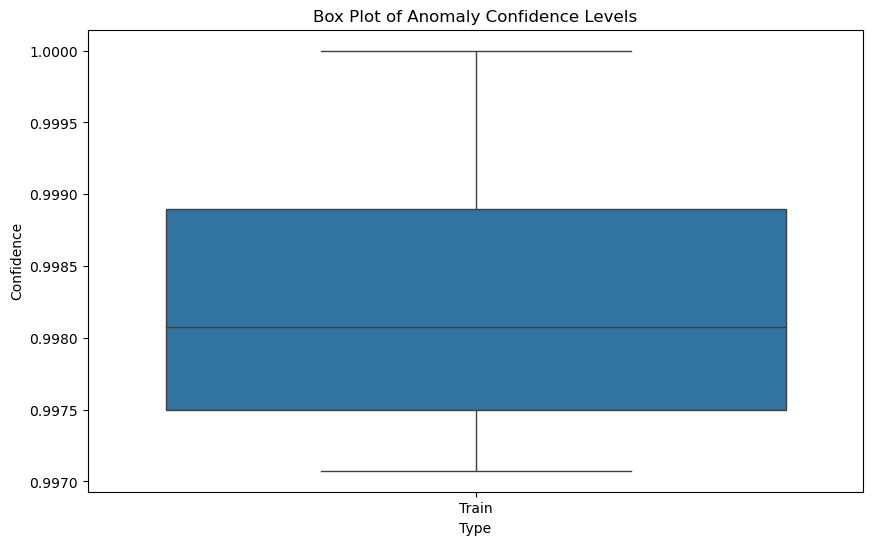

In [25]:
train_confidence_df = pd.DataFrame({'Confidence': train_confidence, 'Type': 'Train'})
test_confidence_df = pd.DataFrame({'Confidence': test_confidence, 'Type': 'Test'})

confidence_data = pd.concat([train_confidence_df, test_confidence_df])

plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Confidence', data=confidence_data)
plt.title("Box Plot of Anomaly Confidence Levels")
plt.show()